In [20]:
import jax.numpy as jnp
from jax import jit 
from jax.flatten_util import ravel_pytree

import numpy as np
import scipy
import matplotlib.pyplot as plt
import interpax

import h5py
from scipy.signal import find_peaks
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
from HelperAndMechanics import *
import progressbar

In [21]:
"""
    Reads in necessary parameters from config.ini
"""
N,size,[] = read_config([],mode = 'chaos')

# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta05.h5', 'r') as f:
    x_temp = f['x_temp'][:]
    x_cm_temp = f['x_cm_temp'][:]
    T = f['T'][:]
    dA = f['dA'][:]
    f.close()


In [56]:
def sm_model(**kwargs_sys):

    #bounds for parameters
    nu_min, nu_max = kwargs_sys['nu_min'], kwargs_sys['nu_max']
    m_min, m_max = kwargs_sys['m_min'], kwargs_sys['m_max']
    l_g_min, l_g_max = kwargs_sys['l_g_min'], kwargs_sys['l_g_max']
    l_p_min, l_p_max = kwargs_sys['l_p_min'], kwargs_sys['l_p_max']
    k_g_min, k_g_max = kwargs_sys['k_g_min'], kwargs_sys['k_g_max']
    k_a_min, k_a_max = kwargs_sys['k_a_min'], kwargs_sys['k_a_max']
    k_p_min, k_p_max = kwargs_sys['k_p_min'], kwargs_sys['k_p_max']
    eta_min, eta_max = kwargs_sys['eta_min'], kwargs_sys['eta_max']

    
    # Interpolated params and coresponding time ,
    x_cm_arr = kwargs_sys['x_cm']
    x_j_arr = kwargs_sys['x_j']
    l_a_arr = kwargs_sys['l_a']
    t_interp = kwargs_sys['t_interp']

    def gen_y0():

        #takes initial conditions from kwargs(data)
        x1_0 = kwargs_sys['x1_0']
        x2_0 = kwargs_sys['x2_0']
        y1_0 = kwargs_sys['y1_0']
        y2_0 = kwargs_sys['y2_0']

        return {'x1':x1_0, 'x2':x2_0, 'y1':y1_0, 'y2':y2_0}

    def gen_params():
        # seed for reproducibility
        

        nu = nu_min + (nu_max - nu_min) * np.random.rand()
        m = m_min + (m_max - m_min) * np.random.rand()

        l_g = l_g_min + (l_g_max - l_g_min) * np.random.rand()
        l_p = l_p_min + (l_p_max - l_p_min) * np.random.rand()

        k_g = k_g_min + (k_g_max - k_g_min) * np.random.rand()
        k_a = k_a_min + (k_a_max - k_a_min) * np.random.rand()
        k_p = k_p_min + (k_p_max - k_p_min) * np.random.rand()
        
        eta0 = eta_min + (eta_max - eta_min) * np.random.rand()
        eta1 = eta_min + (eta_max - eta_min) * np.random.rand()
        eta2 = eta_min + (eta_max - eta_min) * np.random.rand()
        eta3 = eta_min + (eta_max - eta_min) * np.random.rand()

        return {'nu':nu,'m':m,'l_g':l_g,'l_p':l_p,'k_g':k_g, 'k_a':k_a,'k_p':k_p, 'eta0':eta0, 'eta1':eta1 ,'eta2':eta2, 'eta3':eta3 }, {}, {}

        
    @jit
    def eom(xy, t, params, iparams, exparams):
        x = jnp.array([xy['x1'], xy['x2']])
        # get interpolated parameters at corresponding time
        x_cm = t_to_value_x(x_cm_arr,t_interp,t)
        x_j = t_to_value_x(x_j_arr,t_interp,t)
        l_a = t_to_value_l(l_a_arr,t_interp,t)

        #initialize total force
        f = total_force(x, x_j, x_cm, l_a, t, params)

        #initialize eom
        dx1 = xy['y1']
        dx2 = xy['y2']
        dy1 = 1/params['m'] * (f[0] - params['nu'] * xy['y1'])
        dy2 = 1/params['m'] * (f[1] - params['nu'] * xy['y2'])

        return {'x1':dx1, 'x2':dx2, 'y1':dy1, 'y2':dy2}

    @jit
    def loss(xy, params, iparams, exparams, targets):
        
        x1 = xy['x1']
        x2 = xy['x2']
        t_x1 = targets['x1']
        t_x2 = targets['x2']
        return jnp.nanmean((x1-t_x1)**2 + (x2-t_x2)**2 + (params['eta0']-params['eta1']+params['eta2']-params['eta3'])**2)

    return eom, loss, gen_params, gen_y0, {}

### Import Parameters

In [57]:
# Overfitting at 7,4; 7,3
i,j = 5 + 5 * 10, 5 + 2 * 10

N,size,ls = read_config(["l_0","c_a","k_ij","k_j","k_a","m","c_damp","n_0","delta_t_m","it_m","pad"])
l_0, c_a, k_g0, k_p0, k_a0, m0, nu0, eta0, delta_t_m, it_m, pad = ls
eta0 = .5 # np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')[i,j]
l_a0,l_p0,l_g0 = ((eta0-1/2)**2+1/2**2)**(1/2), ((eta0-1/2)**2+1/2**2)**(1/2), l_0

real_params = {'l_p':l_p0,'l_g':l_g0,'k_g':k_g0,'k_p':k_p0,'k_a':k_a0,'m':m0,'nu':nu0,'eta0':eta0,'eta1':eta0,'eta2':eta0,'eta3':eta0}#,'dt':0}

delta_t = delta_t_m * it_m
t_evals = np.linspace(0,N*delta_t,N)
N_interp = int(it_m)*10

In [58]:


# Test for the plot
print(i,j)

T_arr = np.array([T[:,i-1,j-1],T[:,i-1,j],T[:,i,j],T[:,i,j-1]])
dA_arr = np.array([dA[:,i-1,j-1],dA[:,i-1,j],dA[:,i,j],dA[:,i,j-1]])

#np.save('../data/SpringMassModel/StandardPeaks/T_standard10.npy', T_arr[0,t_start:t_stop])
maxima, _ = find_peaks(dA_arr[0],prominence=.0007)
minima, _ = find_peaks(-dA_arr[0],prominence=.0007)

max_indx, min_indx = index_finder(maxima,minima,dA[:,i-1,j-1],start_indx=0)

t_start = maxima[max_indx]
t_stop = minima[min_indx]


55 25


In [59]:
# plt.figure(figsize=(15,10))
# for i in range(10):
#     T_standard = np.load('../data/SpringMassModel/StandardPeaks/T_standard'+str(i+1)+'.npy')
#     T_test = create_T(T_standard, t_evals, t_start, delta_t, t_peak_start,t_peak_stop)
#     plt.plot(T_test[0,:],label= 'T_standard'+str(i+1))


# plt.plot(T_arr[0,t_start:t_stop],linewidth=2.,label="neuer Peak",color='black')
# #place legend outside of plot
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
# # plt.plot(T_test[1,:],label="T_fit")
# # plt.plot(T_test[2,:],label="T_fit")
# # plt.plot(T_test[3,:],label="T_fit")
# plt.legend()

Text(0.5, 0, 'timesteps')

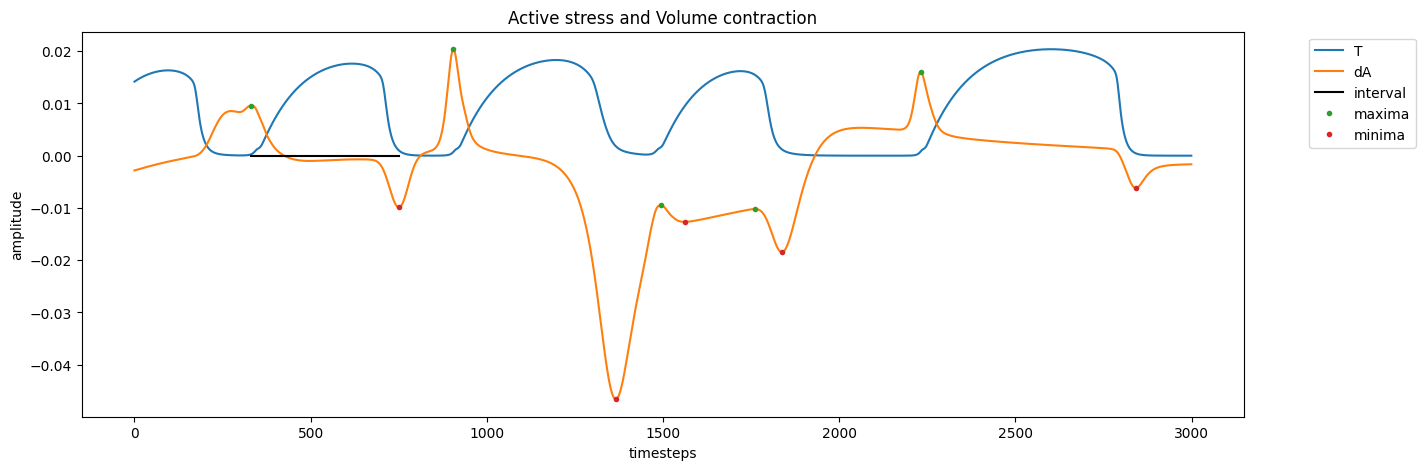

In [60]:
plt.figure(figsize=(15,5))
plt.plot(T_arr[0,:]/T_arr[0,:].max()*abs(dA_arr[0,:].max()),label="T")
plt.plot(dA_arr[0 ,:],label="dA")
plt.plot((t_start,t_stop),(0,0),color = 'black',label="interval")
plt.plot(maxima,dA[maxima,i-1,j-1], ".",label="maxima")
plt.plot(minima,dA[minima,i-1,j-1], ".",label="minima")
#x axis from 3000 to 6000
# plt.xlim(3000,6000)
# plt.ylim(-0.02,0.03)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Active stress and Volume contraction")
plt.ylabel('amplitude')
plt.xlabel('timesteps')
#plt.savefig("activestress_volcontraction_find_peak.png")

In [61]:
# Assuming T_standard is already defined
# # Save the array to a file
#np.save('../data/SpringMassModel/StandardPeaks/T_standard3.npy', T_arr[0,t_start:t_stop])

# # Read the array back from the file


### Find indx for Peak


In [62]:
t_peak_start = np.array([])
t_peak_stop = np.array([])

for k in range(4):
    if k == 0:
        maxima_temp0, _ = find_peaks(dA_arr[k],prominence=.0007)#,height=.001
        minima_temp0, _ = find_peaks(-dA_arr[k],prominence=.0007)#,height=.001
        max_indx, min_indx = index_finder(maxima_temp0,minima_temp0,dA_arr[k],start_indx=0)

        t_start_temp, t_stop_temp = maxima_temp0[max_indx] , minima_temp0[min_indx]
        t_peak_start = np.append(t_peak_start,t_start_temp)
        t_peak_stop = np.append(t_peak_stop,t_stop_temp)
    else:
        maxima_temp, _ = find_peaks(dA_arr[k],prominence=.00001)
        minima_temp, _ = find_peaks(-dA_arr[k],prominence=.00001)
        t_start_temp, t_stop_temp = maxima_temp[np.abs(maxima_temp - maxima_temp0[max_indx]).argmin()] , minima_temp[np.abs(minima_temp - minima_temp0[min_indx]).argmin()]
        t_peak_start = np.append(t_peak_start,t_start_temp)
        t_peak_stop = np.append(t_peak_stop,t_stop_temp)

t_start = maxima_temp0[max_indx]
t_stop = minima_temp0[min_indx]

print('time interval='+str(t_start)+'-'+str(t_stop))

t_evals = np.linspace(0,N*delta_t,N)
t_evals = t_evals[t_start:t_stop] - t_evals[t_start]
#define standard peak
Delta_t_standard = t_stop - t_start
T_standard = np.load('../data/SpringMassModel/StandardPeaks/T_standard4.npy')

time interval=332-750


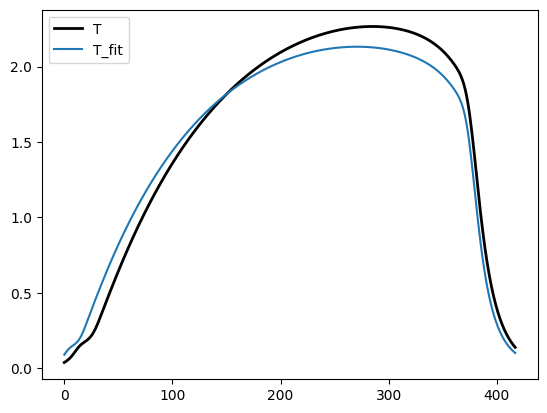

In [63]:
# plt.figure(figsize=(15,10))
# for i in range(10):
#     T_standard = np.load('../data/SpringMassModel/StandardPeaks/T_standard'+str(i+1)+'.npy')
#     T_test = create_T(T_standard, t_evals, t_start, delta_t, t_peak_start,t_peak_stop)
#     plt.plot(T_test[0,:],label= 'T_standard'+str(i+1))
T_test = create_T(T_standard, t_evals, t_start, delta_t, t_peak_start,t_peak_stop)
plt.plot(T_arr[0,t_start:t_stop],linewidth=2.,label="T",color = 'black')
plt.plot(T_test[0,:],label="T_fit")
plt.legend()

In [64]:
x_i,x_j,x_cm,l_a = shape_input_for_adoptode(x_temp[t_start:t_stop,:], x_cm_temp[t_start:t_stop,:],T[t_start:t_stop,:],i,j,l_a0) # i and j specify the cell taken from the grid 
l_a_model = l_a0/(1 + c_a * create_T(T_standard, t_evals, t_start, delta_t, t_peak_start,t_peak_stop))
    
#ersten und letzten 25
# 
#  Werte entfernen
x_i,x_j,x_cm,l_a = x_i[40:-40,:],x_j[:,40:-40,:],x_cm[:,40:-40,:],l_a[:,40:-40]
t_evals = t_evals[40:-40]
l_a_model = l_a_model[:,40:-40]

#arrays interpolieren
t_interp, x_cm_interp = interpolate_x(x_cm,t_evals,N_interp)
t_interp, x_j_interp = interpolate_x(x_j,t_evals,N_interp)
t_interp, l_a_interp = interpolate_scalar(l_a_model,t_evals,N_interp)

y0 = {"x1":x_i[0,0],'x2':x_i[0,1],'y1':(x_i[1,0]-x_i[0,0])/delta_t,'y2':(x_i[1,1]-x_i[0,1])/delta_t,'x_cm':x_cm[:,0,:],'x_j':x_j[:,0,:]}

In [65]:
rel_err = 1        
kwargs_sys = { 
    'nu_min': nu0 - nu0 *rel_err,'nu_max': nu0 + nu0 *rel_err,
    'm_min': m0 - m0 *rel_err,'m_max' : m0 + m0 *rel_err,
    'l_g_min': l_g0 - l_g0 *rel_err,'l_g_max': l_g0 + l_g0 *rel_err,
    'l_p_min': l_p0 - l_p0 *rel_err,'l_p_max': l_p0 + l_p0 *rel_err,
    'k_g_min': k_g0 - k_g0 *rel_err,'k_g_max': k_g0 + k_g0 *rel_err,
    'k_p_min': k_p0 - k_p0 *rel_err,'k_p_max': k_p0 + k_p0 *rel_err,
    'k_a_min': k_a0 - k_a0 *rel_err,'k_a_max': k_a0 + k_a0 *rel_err,
    'eta_min': 0,'eta_max': 1,
    't_interp': t_interp,
    'N_interp': N_interp,
    'x_cm':x_cm_interp,
    'x_j':x_j_interp,
    'l_a':l_a_interp,
    'la0_0':l_a0,
    'x1_0':x_i[0,0],
    'x2_0':x_i[0,1],
    'y1_0':(x_i[1,0]-x_i[0,0])/delta_t,
    'y2_0':(x_i[1,1]-x_i[0,1])/delta_t,
    'N_sys': 1    
}

#upper and lower bounds for parameters

tol = 1
real_params_low = {'l_p':l_p0- l_p0*tol,'l_g':l_g0- l_g0*tol,
                   'k_g':k_g0- k_g0*tol,'k_p':k_p0- k_p0*tol,
                   'k_a':k_a0- k_a0*tol,'m':m0- m0*tol,'nu':nu0- nu0*tol,'eta0':.0, 'eta1':.0, 'eta2':.0, 'eta3':.0}
real_params_up = {'l_p':l_p0+ l_p0*tol,'l_g':l_g0+ l_g0*tol,
                  'k_g':k_g0+ k_g0*tol,'k_p':k_p0+ k_p0*tol,
                  'k_a':k_a0+ k_a0*tol,'m':m0+ m0*tol,'nu':nu0+ nu0*tol,'eta0':1., 'eta1':1., 'eta2':1., 'eta3':1.}

In [66]:
nan_array = jnp.full((1, N-300), 1.)
targets = {"x1":x_i[:,0].reshape((1,len(x_i[:,0]))),'x2':x_i[:,1].reshape((1,len(x_i[:,0]))),'y1':nan_array,'y2':nan_array}
#kwargs for adoptODE
kwargs_adoptODE = {'lr':.1e-2, 'epochs':1000,'N_backups':4,
                   'lower_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']-0*y0['y1'],'y2':y0['y2']-0*y0['y2'] },
                   'upper_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']+0*y0['y1'],'y2':y0['y2']+0*y0['y2'] },
                   'lower_b': real_params_low,
                   'upper_b': real_params_up}
#define the dataset
dataset2 = dataset_adoptODE(sm_model,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE, 
                                true_params = real_params
                                )

In [67]:
params_final, losses, errors, params_history = train_adoptODE(dataset2,save_interval=100)

Epoch 000:  Loss: 1.3e-01,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 8.7e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 100:  Loss: 1.2e-03,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 8.7e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 200:  Loss: 2.6e-04,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 8.8e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 300:  Loss: 2.5e-05,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 8.9e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 400:  Loss: 2.8e-06,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 8.9e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 500:  Loss: 8.4e-07,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 8.8e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 600:  Loss: 3.7e-07,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 8.9e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 700:  Loss: 1.4e-07,  Params Err.: 1.4e+01, y0 error: na

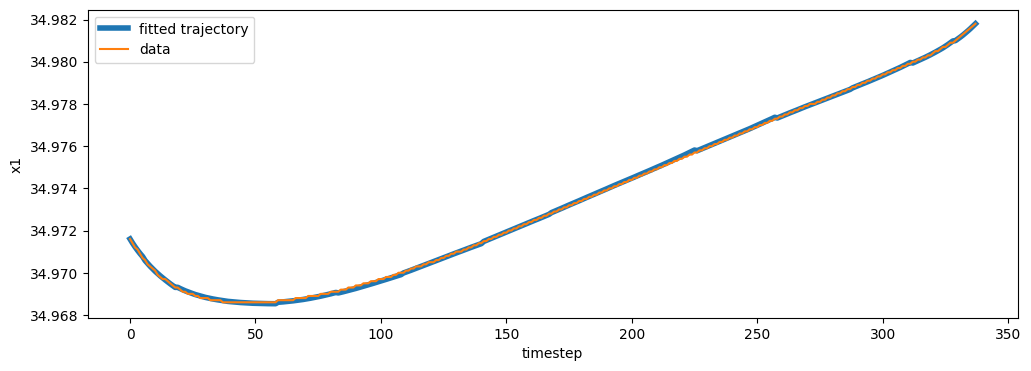

In [68]:
plt.figure(figsize=(12, 4))
plt.plot(dataset2.ys_sol['x1'][0,0:],linewidth = 4,label= 'fitted trajectory')
plt.plot(x_i[0:,0],label = 'data')
plt.ylabel('x1')
plt.xlabel('timestep')
plt.legend()
#plt.savefig("trajectory_overfittet2.png")

In [69]:
for i in range(4):
    print(dataset2.params_train[f'eta{i}'])
print(losses[-1])

0.34716654
0.32286528
0.31360236
0.33839908
[1.3734694e-07]


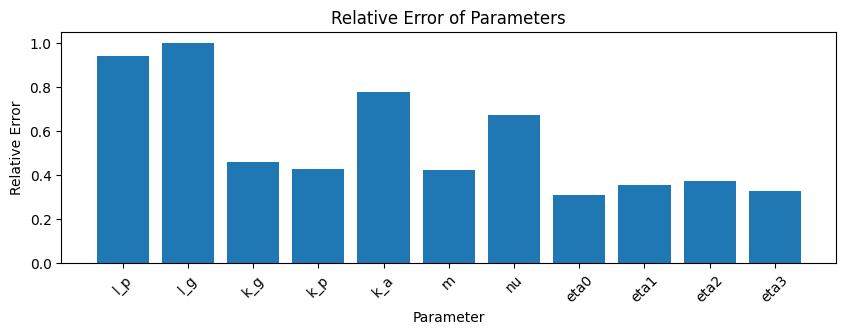

In [70]:
# Get the parameter names
param_names = list(real_params.keys())

# Calculate the relative error for each parameter
relative_errors = []
for param_name in param_names:
    real_value = real_params.get(param_name, np.nan)
    train_value = dataset2.params_train.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)

# Plot the relative errors
plt.figure(figsize=(10, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()